# Cargando bibliotecas a usar en el proyecto de analisis

In [1]:
# 1. Importar las bibliotecas necesarias para el analisis, lo hacemos una sola vez.
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
import shap

# 2. Cargar los datos desde la URL
url = 'https://raw.githubusercontent.com/ingridcristh/challenge2-data-science-LATAM/main/TelecomX_Data.json'
datos = pd.read_json(url)

# ETL, que nos dice la carga de data

## que tipo de datos nos enviaron para analizar

In [2]:
# ¿Que tipos de datos tiene la data que nos envian?
print (datos.info() )
print (datos.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   customerID  7267 non-null   object
 1   Churn       7267 non-null   object
 2   customer    7267 non-null   object
 3   phone       7267 non-null   object
 4   internet    7267 non-null   object
 5   account     7267 non-null   object
dtypes: object(6)
memory usage: 340.8+ KB
None
   customerID Churn                                           customer  \
0  0002-ORFBO    No  {'gender': 'Female', 'SeniorCitizen': 0, 'Part...   
1  0003-MKNFE    No  {'gender': 'Male', 'SeniorCitizen': 0, 'Partne...   
2  0004-TLHLJ   Yes  {'gender': 'Male', 'SeniorCitizen': 0, 'Partne...   
3  0011-IGKFF   Yes  {'gender': 'Male', 'SeniorCitizen': 1, 'Partne...   
4  0013-EXCHZ   Yes  {'gender': 'Female', 'SeniorCitizen': 1, 'Part...   

                                             phone  \
0   {'PhoneService': 'Yes', 

## lo anterior nos indica campos anidados, hay que normalizar

In [3]:
# Hacemos la petición a la URL y la convertimos a formato JSON
response = requests.get(url)
json_data = response.json()

In [4]:
# 3. normalizar la estructura anidada y crear el DataFrame, paso clave para leer correctamente la fuente de datos
datos = pd.json_normalize(json_data)

## Limpieza da columnas.

In [5]:
# --- Proceso de Transformación (ETL) ---

# 4. Limpiar los nombres de las columnas (reemplazar '.' con '_')
datos.columns = datos.columns.str.replace('.', '_', regex=False)

# 5. Corregir el tipo de dato de 'account_Charges_Total'
datos['account_Charges_Total'] = pd.to_numeric(datos['account_Charges_Total'], errors='coerce')

# 6. Manejar valores nulos (rellenarlos con 0)
datos['account_Charges_Total'].fillna(0, inplace=True)

/tmp/ipython-input-3773106109.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  datos['account_Charges_Total'].fillna(0, inplace=True)


## Información del DataFrame normalizado

In [6]:
print("--- Información del DataFrame ---")
datos.info()

--- Información del DataFrame ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerID                 7267 non-null   object 
 1   Churn                      7267 non-null   object 
 2   customer_gender            7267 non-null   object 
 3   customer_SeniorCitizen     7267 non-null   int64  
 4   customer_Partner           7267 non-null   object 
 5   customer_Dependents        7267 non-null   object 
 6   customer_tenure            7267 non-null   int64  
 7   phone_PhoneService         7267 non-null   object 
 8   phone_MultipleLines        7267 non-null   object 
 9   internet_InternetService   7267 non-null   object 
 10  internet_OnlineSecurity    7267 non-null   object 
 11  internet_OnlineBackup      7267 non-null   object 
 12  internet_DeviceProtection  7267 non-null   object 
 13  internet_TechS

# Diccionario de datos normalizado

- customerID: número de identificación único de cada cliente
- Churn: si el cliente dejó o no la empresa
- customer_gender : género (masculino y femenino)
- customer_SeniorCitizen: información sobre si un cliente tiene o no una edad igual o mayor a 65 años
- customer_Partner: si el cliente tiene o no una pareja
- customer_Dependents: si el cliente tiene o no dependientes
- customer_tenure: meses de contrato del cliente
- phone_PhoneService: suscripción al servicio telefónico
- phone_MultipleLines: suscripción a más de una línea telefónica
- internet_InternetService: suscripción a un proveedor de internet
- internet_OnlineSecurity: suscripción adicional de seguridad en línea
- internet_OnlineBackup: suscripción adicional de respaldo en línea
- internet_DeviceProtection: suscripción adicional de protección del dispositivo
- internet_TechSupport: suscripción adicional de soporte técnico, menor tiempo de espera
- internet_StreamingTV: suscripción de televisión por cable
- internet_StreamingMovies: suscripción de streaming de películas
- account_Contract: tipo de contrato
- account_PaperlessBilling: si el cliente prefiere recibir la factura en línea
- account_PaymentMethod: forma de pago
- account_Charges_Monthly: total de todos los servicios del cliente por mes
- account_Charges_Total: total gastado por el cliente

In [7]:
datos.sample(20)

,customerID,Churn,customer_gender,customer_SeniorCitizen,customer_Partner,customer_Dependents,customer_tenure,phone_PhoneService,phone_MultipleLines,internet_InternetService,...,internet_OnlineBackup,internet_DeviceProtection,internet_TechSupport,internet_StreamingTV,internet_StreamingMovies,account_Contract,account_PaperlessBilling,account_PaymentMethod,account_Charges_Monthly,account_Charges_Total
5590,7636-XUHWW,No,Male,0,No,No,2,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Credit card (automatic),19.90,33.70
5267,7184-LRUUR,No,Female,0,No,No,22,Yes,No,DSL,...,Yes,Yes,No,Yes,No,One year,No,Bank transfer (automatic),65.25,1441.80
44,0074-HDKDG,No,Male,0,Yes,Yes,25,Yes,No,DSL,...,Yes,Yes,No,No,No,One year,Yes,Bank transfer (automatic),61.60,1611.00
636,0906-QVPMS,No,Male,0,Yes,No,72,Yes,Yes,Fiber optic,...,Yes,Yes,Yes,Yes,Yes,Two year,No,Bank transfer (automatic),115.15,8349.45
521,0739-UUAJR,No,Female,0,Yes,Yes,72,No,No phone service,DSL,...,No,Yes,No,Yes,Yes,Two year,Yes,Credit card (automatic),53.80,3952.45
6505,8942-DBMHZ,No,Male,0,No,No,12,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.45,255.35
2126,2984-MIIZL,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Bank transfer (automatic),74.80,321.90
1707,2428-HYUNX,No,Male,1,Yes,No,44,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Credit card (automatic),19.35,847.25
4976,6807-HWZBE,,Male,0,Yes,No,2,Yes,Yes,Fiber optic,...,No,Yes,No,Yes,No,Month-to-month,Yes,Electronic check,91.45,171.45
5452,7470-MCQTK,Yes,Female,0,Yes,No,13,No,No phone service,DSL,...,No,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),48.75,633.40


In [8]:
# --- CUANTIFICACIÓN DE VALORES ÚNICOS POR COLUMNA ---

# Iteramos a través de cada columna del DataFrame
for column in datos.columns:
    print(f"--- Columna: {column} ---")

    # Obtenemos y mostramos el conteo de cada valor único
    value_counts = datos[column].value_counts()
    print(value_counts)

    print("\n" + "="*50 + "\n")

--- Columna: customerID ---
customerID
9995-HOTOH    1
0002-ORFBO    1
0003-MKNFE    1
9970-QBCDA    1
9968-FFVVH    1
             ..
0014-BMAQU    1
0013-SMEOE    1
0013-MHZWF    1
0013-EXCHZ    1
0011-IGKFF    1
Name: count, Length: 7267, dtype: int64


--- Columna: Churn ---
Churn
No     5174
Yes    1869
        224
Name: count, dtype: int64


--- Columna: customer_gender ---
customer_gender
Male      3675
Female    3592
Name: count, dtype: int64


--- Columna: customer_SeniorCitizen ---
customer_SeniorCitizen
0    6085
1    1182
Name: count, dtype: int64


--- Columna: customer_Partner ---
customer_Partner
No     3749
Yes    3518
Name: count, dtype: int64


--- Columna: customer_Dependents ---
customer_Dependents
No     5086
Yes    2181
Name: count, dtype: int64


--- Columna: customer_tenure ---
customer_tenure
1     634
72    369
2     246
3     207
4     185
     ... 
28     60
39     59
44     54
36     50
0      11
Name: count, Length: 73, dtype: int64


--- Columna: phone_Ph

# ESTANDARIZACIÓN DE VALORES CATEGÓRICOS

In [9]:
# --- ESTANDARIZACIÓN DEFINITIVA CON VERIFICACIÓN COMPLETA ---
# Si no tiene el servicio internet por ejemplo, se induce que no tiene los otros servicios.

# 1. Lista de todas las columnas de servicios adicionales a estandarizar
columnas_a_estandarizar = [
    'phone_MultipleLines',
    'internet_OnlineSecurity',
    'internet_OnlineBackup',
    'internet_DeviceProtection',
    'internet_TechSupport',
    'internet_StreamingTV',
    'internet_StreamingMovies'
]

# 2. Diccionario con los valores a reemplazar
valores_a_reemplazar = {
    'No internet service': 'No',
    'No phone service': 'No'
}

print("--- APLICANDO LA ESTANDARIZACIÓN ---\n")

# 3. Iteramos y aplicamos el reemplazo en cada columna de la lista
for columna in columnas_a_estandarizar:
    datos[columna] = datos[columna].replace(valores_a_reemplazar)

print("¡Proceso de reemplazo completado!\n")
print("="*50)
print("\n--- VERIFICACIÓN DESPUÉS DE LA ESTANDARIZACIÓN ---\n")

# 4. Iteramos de nuevo para mostrar el resultado de CADA columna limpiada
for columna in columnas_a_estandarizar:
    print(f"Valores en '{columna}':")
    print(datos[columna].value_counts())
    print("-" * 30)

--- APLICANDO LA ESTANDARIZACIÓN ---

¡Proceso de reemplazo completado!


--- VERIFICACIÓN DESPUÉS DE LA ESTANDARIZACIÓN ---

Valores en 'phone_MultipleLines':
phone_MultipleLines
No     4202
Yes    3065
Name: count, dtype: int64
------------------------------
Valores en 'internet_OnlineSecurity':
internet_OnlineSecurity
No     5189
Yes    2078
Name: count, dtype: int64
------------------------------
Valores en 'internet_OnlineBackup':
internet_OnlineBackup
No     4763
Yes    2504
Name: count, dtype: int64
------------------------------
Valores en 'internet_DeviceProtection':
internet_DeviceProtection
No     4776
Yes    2491
Name: count, dtype: int64
------------------------------
Valores en 'internet_TechSupport':
internet_TechSupport
No     5163
Yes    2104
Name: count, dtype: int64
------------------------------
Valores en 'internet_StreamingTV':
internet_StreamingTV
No     4477
Yes    2790
Name: count, dtype: int64
------------------------------
Valores en 'internet_StreamingMovies

In [10]:
datos.sample(20)

,customerID,Churn,customer_gender,customer_SeniorCitizen,customer_Partner,customer_Dependents,customer_tenure,phone_PhoneService,phone_MultipleLines,internet_InternetService,...,internet_OnlineBackup,internet_DeviceProtection,internet_TechSupport,internet_StreamingTV,internet_StreamingMovies,account_Contract,account_PaperlessBilling,account_PaymentMethod,account_Charges_Monthly,account_Charges_Total
3079,4291-SHSBH,No,Male,0,No,No,7,Yes,No,Fiber optic,...,No,No,No,No,No,Month-to-month,Yes,Electronic check,69.55,521.35
5879,8039-EQPIM,No,Male,0,Yes,No,69,No,No,DSL,...,No,Yes,Yes,Yes,Yes,Two year,No,Bank transfer (automatic),60.25,4055.50
3174,4431-EDMIQ,No,Female,0,Yes,Yes,7,Yes,No,DSL,...,Yes,Yes,Yes,Yes,No,Month-to-month,Yes,Electronic check,75.70,554.05
3013,4188-FRABG,No,Male,0,Yes,No,57,Yes,Yes,Fiber optic,...,Yes,Yes,Yes,Yes,No,Month-to-month,Yes,Electronic check,103.05,5925.75
2881,3996-ZNWYK,No,Male,1,Yes,Yes,71,Yes,No,No,...,No,No,No,No,No,Two year,No,Credit card (automatic),19.80,1388.45
6631,9114-DPSIA,No,Male,0,Yes,Yes,72,Yes,Yes,DSL,...,Yes,Yes,Yes,No,Yes,Two year,No,Credit card (automatic),81.00,5750.00
5006,6848-YLDFR,No,Male,0,Yes,Yes,58,Yes,No,DSL,...,Yes,No,Yes,Yes,Yes,One year,Yes,Credit card (automatic),75.20,4300.80
6346,8732-BBLMG,,Female,0,No,No,5,No,No,DSL,...,Yes,No,No,Yes,Yes,Month-to-month,Yes,Credit card (automatic),50.95,229.40
451,0639-QDHAY,,Female,0,No,No,22,Yes,No,Fiber optic,...,No,No,Yes,No,Yes,Month-to-month,Yes,Electronic check,89.05,1886.25
2004,2832-SCUCO,No,Female,0,No,No,2,Yes,No,No,...,No,No,No,No,No,Month-to-month,No,Electronic check,19.90,57.40


In [11]:
# dado que campo Churn tiene algunos vacios, los descartamos...

print("--- ANTES DE LA LIMPIEZA ---")
print(f"Número total de registros: {len(datos)}")
print("Valores únicos en 'Churn':")
print(datos['Churn'].unique())
print("\n" + "="*50 + "\n")


# 1. Reemplazamos las celdas con solo espacios en blanco por valores nulos (NaN)
# El regex=True busca celdas que estén vacías o solo contengan espacios
datos['Churn'] = datos['Churn'].replace(r'^\s*$', np.nan, regex=True)


# 2. Ahora sí, eliminamos las filas con valores nulos en 'Churn'
datos.dropna(subset=['Churn'], inplace=True)

print("--- DESPUÉS DE LA LIMPIEZA ---")
print(f"Número total de registros: {len(datos)}")
print("Valores únicos en 'Churn':")
print(datos['Churn'].unique())
print("\n¡Limpieza completada! Ahora 'Churn' solo contiene 'No' y 'Yes'.")

--- ANTES DE LA LIMPIEZA ---
Número total de registros: 7267
Valores únicos en 'Churn':
['No' 'Yes' '']


--- DESPUÉS DE LA LIMPIEZA ---
Número total de registros: 7043
Valores únicos en 'Churn':
['No' 'Yes']

¡Limpieza completada! Ahora 'Churn' solo contiene 'No' y 'Yes'.


# Analisis Exploratorios

## Tasa de cancelación (Churn)

In [12]:
# --- GRÁFICO DE TASA DE CANCELACIÓN TOTAL CON PLOTLY ---

# Contamos los valores en la columna 'Churn'
churn_counts = datos['Churn'].value_counts().reset_index()
churn_counts.columns = ['Churn', 'Count'] # Renombramos las columnas

# --- Creación del Gráfico de Torta Interactivo ---

fig = px.pie(
    churn_counts,
    values='Count',
    names='Churn',
    title='Tasa de Cancelación (Churn) del Universo Total de Clientes',
    color_discrete_map={'Yes': 'orangered', 'No': 'royalblue'}, # Asignamos colores
    hole=.3 # Le da un estilo de "dona"
)

# Mejoramos la información que se muestra en el gráfico
fig.update_traces(textinfo='percent+label', pull=[0.1, 0])

fig.show()

## Tasa de Cancelación x Variables.

In [13]:
# --- GRÁFICO INTERACTIVO DE FACTORES DE CHURN CON PLOTLY ---

# Lista de variables categóricas a analizar
variables_a_analizar = [
    'customer_gender', 'customer_SeniorCitizen', 'customer_Partner',
    'customer_Dependents', 'phone_PhoneService', 'phone_MultipleLines',
    'internet_InternetService', 'internet_OnlineSecurity', 'internet_OnlineBackup',
    'internet_DeviceProtection', 'internet_TechSupport', 'internet_StreamingTV',
    'internet_StreamingMovies', 'account_Contract', 'account_PaperlessBilling',
    'account_PaymentMethod'
]

# Lista para almacenar los resultados de cada variable
all_churn_rates = []

# Calculamos la tasa de churn para cada categoría en cada variable
for variable in variables_a_analizar:
    summary = datos.groupby(variable)['Churn'].value_counts(normalize=True).unstack()
    if 'Yes' in summary.columns:
        churn_rates = summary['Yes'].reset_index()
        churn_rates.columns = ['Category', 'Churn_Rate']
        churn_rates['Variable'] = variable
        all_churn_rates.append(churn_rates)

# Combinamos todos los resultados en un solo DataFrame
df_all_rates = pd.concat(all_churn_rates)

# Creamos una columna combinada para las etiquetas del gráfico
df_all_rates['Feature'] = df_all_rates['Variable'] + ": " + df_all_rates['Category'].astype(str)

# Convertimos la tasa de churn a porcentaje
df_all_rates['Churn_Rate'] = df_all_rates['Churn_Rate'] * 100

# Ordenamos el DataFrame por la tasa de churn de mayor a menor para la visualización inicial
df_sorted = df_all_rates.sort_values(by='Churn_Rate', ascending=False)


# --- Creación del Gráfico Interactivo con Plotly ---

fig = px.bar(
    df_sorted,
    x='Churn_Rate',
    y='Feature',
    color='Variable',  # ¡Aquí está la magia! Asigna un color a cada variable principal
    orientation='h',   # Gráfico de barras horizontales
    title='Ranking Interactivo de Factores por Tasa de Cancelación (Churn)',
    labels={'Churn_Rate': 'Tasa de Cancelación (%)', 'Feature': 'Característica del Cliente'},
    text='Churn_Rate', # Muestra el valor de la tasa en la barra
    height=800, # Ajusta la altura para que quepan todas las barras
    color_continuous_scale='Plasma' # Puedes probar también 'Viridis', 'Magma', etc.
)

# Mejoramos el formato del texto en las barras y la orientación del gráfico
fig.update_traces(texttemplate='%{text:.2f}%', textposition='outside')
fig.update_layout(yaxis={'categoryorder':'total ascending'}) # Mantiene el orden de las barras

fig.show()

## Los que Cancelaron que caracteristicas tienen?

In [14]:
import plotly.express as px
import pandas as pd

# 1. Filtramos los datos para quedarnos solo con los que cancelaron
datos_churn = datos[datos['Churn'] == 'Yes'].copy()

# 2. Definimos las características de servicio clave que queremos medir
# Esta lista contiene tuplas con (Nombre de la Característica, Columna, Valor)
caracteristicas_clave = [
    ("Contrataron Fibra Óptica", 'internet_InternetService', 'Fiber optic'),
    ("NO Tenían Soporte Técnico", 'internet_TechSupport', 'No'),
    ("NO Tenían Seguridad Online", 'internet_OnlineSecurity', 'No'),
    ("Tenían Facturación Sin Papel", 'account_PaperlessBilling', 'Yes'),
    ("NO Tenían Respaldo Online", 'internet_OnlineBackup', 'No'),
    ("Tenían Servicio Telefónico", 'phone_PhoneService', 'Yes')
]

# 3. Calculamos el porcentaje para cada característica
resultados = []
total_churned = len(datos_churn)

for nombre, columna, valor in caracteristicas_clave:
    count = datos_churn[datos_churn[columna] == valor].shape[0]
    percentage = round((count / total_churned) * 100, 1)
    resultados.append({'Característica': nombre, 'Porcentaje': percentage})

# 4. Creamos un DataFrame con los resultados y lo ordenamos
df_perfil = pd.DataFrame(resultados).sort_values(by='Porcentaje', ascending=False)

# 5. Creamos el gráfico de barras interactivo
fig = px.bar(
    df_perfil,
    x='Porcentaje',
    y='Característica',
    orientation='h',
    title='Perfil de Servicios de los Clientes que Cancelaron',
    text='Porcentaje',
    labels={'Porcentaje': '% de Clientes que Cancelaron', 'Característica': 'Característica del Servicio'}
)

fig.update_traces(
    texttemplate='%{text}%',
    textposition='outside',
    marker_color='#EF553B' # Un color rojo para indicar "cancelación"
)
fig.update_layout(yaxis={'categoryorder':'total ascending'}) # Ordena las barras

fig.show()

In [15]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# --- 1. Filtramos los datos para quedarnos solo con los que cancelaron ---
datos_churn = datos[datos['Churn'] == 'Yes'].copy()


# --- 2. Creación de la figura con subplots ---
fig = make_subplots(
    rows=1, cols=3,
    subplot_titles=(
        "Servicio de Internet (% de Clientes que Cancelaron)",
        "Tipo de Contrato (% de Clientes que Cancelaron)",
        "Distribución de Cargos Totales (Clientes que Cancelaron)" # <-- Título cambiado
    ),
    specs=[[{"type": "bar"}, {"type": "bar"}, {"type": "histogram"}]]
)

# --- 3. Generación y adición de cada gráfico ---

# Gráfico 1: internet_InternetService (en porcentaje)
internet_counts = datos_churn['internet_InternetService'].value_counts(normalize=True).mul(100).round(1).reset_index()
internet_counts.columns = ['Category', 'Percentage']
fig.add_trace(
    go.Bar(
        x=internet_counts['Category'], y=internet_counts['Percentage'],
        text=internet_counts['Percentage'], texttemplate='%{text}%', textposition='outside',
        name='Servicio de Internet'
    ),
    row=1, col=1
)

# Gráfico 2: account_Contract (en porcentaje)
contract_counts = datos_churn['account_Contract'].value_counts(normalize=True).mul(100).round(1).reset_index()
contract_counts.columns = ['Category', 'Percentage']
fig.add_trace(
    go.Bar(
        x=contract_counts['Category'], y=contract_counts['Percentage'],
        text=contract_counts['Percentage'], texttemplate='%{text}%', textposition='outside',
        name='Tipo de Contrato'
    ),
    row=1, col=2
)

# Gráfico 3: REEMPLAZO POR account_Charges_Total (Histograma)
fig.add_trace(
    go.Histogram(x=datos_churn['account_Charges_Total'], name='Cargos Totales'),
    row=1, col=3
)

# --- 4. Actualización del diseño general ---
fig.update_layout(
    title_text="Análisis del Perfil de Clientes que Cancelaron (Churn = 'Yes')",
    showlegend=False,
    height=500
)
fig.update_yaxes(title_text="Porcentaje de Clientes (%)", row=1, col=1)
fig.update_yaxes(title_text="Porcentaje de Clientes (%)", row=1, col=2)
fig.update_yaxes(title_text="Número de Clientes", row=1, col=3)

fig.show()

In [16]:
# --- ANÁLISIS DE LA TASA DE CANCELACIÓN POR MÉTODO DE PAGO ---

# Asegúrate de tener tu DataFrame 'datos' limpio y estandarizado

print("--- Tasa de Cancelación por Método de Pago ---\n")

# 1. Obtenemos la lista de métodos de pago únicos
metodos_de_pago = datos['account_PaymentMethod'].unique()

# 2. Iteramos sobre cada método de pago para analizarlo
for metodo in metodos_de_pago:
    # Filtramos el DataFrame para tener solo los clientes con ese método de pago
    datos_metodo = datos[datos['account_PaymentMethod'] == metodo].copy()

    # Calculamos la tasa de churn para ese grupo específico
    # Usamos un try-except por si alguna categoría no tuviera casos de 'Yes'
    try:
        churn_rate = (datos_metodo['Churn'].value_counts(normalize=True)['Yes'] * 100).round(2)
        print(f"Tasa de cancelación para '{metodo}': {churn_rate}%")
    except KeyError:
        print(f"Tasa de cancelación para '{metodo}': 0.0%")

--- Tasa de Cancelación por Método de Pago ---

Tasa de cancelación para 'Mailed check': 19.11%
Tasa de cancelación para 'Electronic check': 45.29%
Tasa de cancelación para 'Credit card (automatic)': 15.24%
Tasa de cancelación para 'Bank transfer (automatic)': 16.71%


In [17]:
# --- ANÁLISIS DE LA HIPÓTESIS SOBRE FIBRA ÓPTICA ---

# 1. Filtrar para tener solo los clientes con Fibra Óptica
datos_fibra = datos[datos['internet_InternetService'] == 'Fiber optic'].copy()

# 2. Calcular la tasa de churn GENERAL para los clientes de Fibra Óptica
churn_rate_fibra_general = (datos_fibra['Churn'].value_counts(normalize=True)['Yes'] * 100).round(2)
print(f"Tasa de cancelación (Churn) para TODOS los clientes con Fibra Óptica: {churn_rate_fibra_general}%\n")

# 3. Ahora, analicemos a los que tienen Fibra Óptica PERO SIN Soporte Técnico
datos_fibra_sin_soporte = datos_fibra[datos_fibra['internet_TechSupport'] == 'No'].copy()
churn_rate_fibra_sin_soporte = (datos_fibra_sin_soporte['Churn'].value_counts(normalize=True)['Yes'] * 100).round(2)
print(f"Tasa de cancelación para clientes de Fibra Óptica SIN Soporte Técnico: {churn_rate_fibra_sin_soporte}%\n")

# 4. Analicemos a los que tienen Fibra Óptica PERO SIN Seguridad Online
datos_fibra_sin_seguridad = datos_fibra[datos_fibra['internet_OnlineSecurity'] == 'No'].copy()
churn_rate_fibra_sin_seguridad = (datos_fibra_sin_seguridad['Churn'].value_counts(normalize=True)['Yes'] * 100).round(2)

print(f"Tasa de cancelación para clientes de Fibra Óptica SIN Seguridad Online: {churn_rate_fibra_sin_seguridad}%\n")

Tasa de cancelación (Churn) para TODOS los clientes con Fibra Óptica: 41.89%

Tasa de cancelación para clientes de Fibra Óptica SIN Soporte Técnico: 49.37%

Tasa de cancelación para clientes de Fibra Óptica SIN Seguridad Online: 49.36%



In [18]:
# --- ANÁLISIS DE LA TASA DE CANCELACIÓN POR TIPO DE CONTRATO ---

# Asegúrate de tener tu DataFrame 'datos' limpio y estandarizado

print("--- Tasa de Cancelación por Tipo de Contrato ---\n")

# 1. Obtenemos la lista de tipos de contrato únicos
tipos_de_contrato = datos['account_Contract'].unique()

# 2. Iteramos sobre cada tipo de contrato para analizarlo
for contrato in tipos_de_contrato:
    # Filtramos el DataFrame para tener solo los clientes con ese tipo de contrato
    datos_contrato = datos[datos['account_Contract'] == contrato].copy()

    # Calculamos la tasa de churn para ese grupo específico
    try:
        churn_rate = (datos_contrato['Churn'].value_counts(normalize=True)['Yes'] * 100).round(2)
        print(f"Tasa de cancelación para Contrato '{contrato}': {churn_rate}%")
    except KeyError:
        print(f"Tasa de cancelación para Contrato '{contrato}': 0.0%")

--- Tasa de Cancelación por Tipo de Contrato ---

Tasa de cancelación para Contrato 'One year': 11.27%
Tasa de cancelación para Contrato 'Month-to-month': 42.71%
Tasa de cancelación para Contrato 'Two year': 2.83%


In [20]:
# --- ANÁLISIS DE LA TASA DE CANCELACIÓN POR TIPO DE SERVICIO DE INTERNET ---

print("--- Tasa de Cancelación por Tipo de Servicio de Internet ---\n")

# 1. Obtenemos la lista de tipos de servicio de internet únicos
tipos_de_servicio = datos['internet_InternetService'].unique()

# 2. Iteramos sobre cada tipo de servicio para analizarlo
for servicio in tipos_de_servicio:
    # Filtramos el DataFrame para tener solo los clientes con ese tipo de servicio
    datos_servicio = datos[datos['internet_InternetService'] == servicio].copy()

    # Calculamos la tasa de churn para ese grupo específico
    try:
        churn_rate = (datos_servicio['Churn'].value_counts(normalize=True)['Yes'] * 100).round(2)
        print(f"Tasa de cancelación para Servicio '{servicio}': {churn_rate}%")
    except KeyError:
        print(f"Tasa de cancelación para Servicio '{servicio}': 0.0%")

--- Tasa de Cancelación por Tipo de Servicio de Internet ---

Tasa de cancelación para Servicio 'DSL': 18.96%
Tasa de cancelación para Servicio 'Fiber optic': 41.89%
Tasa de cancelación para Servicio 'No': 7.4%


In [21]:
# --- ANÁLISIS SISTEMÁTICO DE TASA DE CANCELACIÓN POR VARIABLE (CON FORMATO %) ---

# Lista de todas las variables categóricas que queremos analizar
variables_a_analizar = [
    'customer_gender',
    'customer_SeniorCitizen',
    'customer_Partner',
    'customer_Dependents',
    'phone_PhoneService',
    'phone_MultipleLines',
    'internet_InternetService',
    'internet_OnlineSecurity',
    'internet_OnlineBackup',
    'internet_DeviceProtection',
    'internet_TechSupport',
    'internet_StreamingTV',
    'internet_StreamingMovies',
    'account_Contract',
    'account_PaperlessBilling',
    'account_PaymentMethod'
]

# Iteramos sobre cada variable en la lista para analizarla
for variable in variables_a_analizar:
    print(f"--- Análisis de Churn por: {variable} ---")

    # Agrupamos por la variable y el churn, y contamos los clientes
    # Usamos .unstack(fill_value=0) para evitar errores si una categoría no tiene 'Yes' o 'No'
    churn_summary = datos.groupby([variable, 'Churn'])['customerID'].count().unstack(fill_value=0)

    # Calculamos la tasa de churn
    churn_summary['Churn_Rate'] = (churn_summary['Yes'] / (churn_summary['No'] + churn_summary['Yes']) * 100).round(2)

    # ----> ¡AQUÍ ESTÁ EL CAMBIO! <----
    # Convertimos la columna a texto y añadimos el símbolo '%'
    churn_summary['Churn_Rate'] = churn_summary['Churn_Rate'].astype(str) + '%'

    # Mostramos el resumen
    print(churn_summary)
    print("\n" + "="*50 + "\n")

--- Análisis de Churn por: customer_gender ---
Churn              No  Yes Churn_Rate
customer_gender                      
Female           2549  939     26.92%
Male             2625  930     26.16%


--- Análisis de Churn por: customer_SeniorCitizen ---
Churn                     No   Yes Churn_Rate
customer_SeniorCitizen                       
0                       4508  1393     23.61%
1                        666   476     41.68%


--- Análisis de Churn por: customer_Partner ---
Churn               No   Yes Churn_Rate
customer_Partner                       
No                2441  1200     32.96%
Yes               2733   669     19.66%


--- Análisis de Churn por: customer_Dependents ---
Churn                  No   Yes Churn_Rate
customer_Dependents                       
No                   3390  1543     31.28%
Yes                  1784   326     15.45%


--- Análisis de Churn por: phone_PhoneService ---
Churn                 No   Yes Churn_Rate
phone_PhoneService              

# Análisis de "Compromiso"

### ¿Cómo Interactuar con este Gráfico?
Vista General: Verás dos grandes secciones: "Yes" y "No" para el Churn.

Haz Clic para Explorar: Haz clic en la sección "Yes". El gráfico se redibujará para mostrarte solo los datos de los clientes que cancelaron. Verás anillos que representan el número de servicios que tenían (0, 1, 2, etc.).

Profundiza Más: Ahora, haz clic en uno de esos números (por ejemplo, en el anillo "1"). El gráfico se volverá a centrar para mostrarte cuáles fueron los servicios únicos más comunes entre los clientes que cancelaron y que solo tenían un servicio adicional.

Para Volver Atrás: Haz clic en el centro del círculo para subir un nivel en la jerarquía.

Este gráfico da el poder de navegar dentro de los datos y responder preguntas muy específicas sobre la combinación de servicios que tenían los clientes que abandonan.

In [ ]:
# --- 1. Preparación de los datos (igual que antes) ---
servicios_adicionales = [
    'internet_OnlineSecurity', 'internet_OnlineBackup', 'internet_DeviceProtection',
    'internet_TechSupport', 'internet_StreamingTV', 'internet_StreamingMovies'
]

df_melted = datos.melt(
    id_vars=['customerID', 'Churn', 'NumberOfAddonServices'],
    value_vars=servicios_adicionales,
    var_name='ServiceType',
    value_name='HasService'
)

df_services_only = df_melted[df_melted['HasService'] == 'Yes'].copy()
df_services_only['count'] = 1

# --- 2. Creación del Gráfico Solar (con el tamaño ajustado) ---
fig = px.sunburst(
    df_services_only,
    path=['Churn', 'NumberOfAddonServices', 'ServiceType'],
    values='count',
    title='Desglose Jerárquico de Servicios por Estado de Cancelación (interactivo)',
    color='NumberOfAddonServices',
    color_continuous_scale=px.colors.sequential.Plasma,
    height=700  # <--- AQUÍ ESTÁ EL CAMBIO: Aumentamos la altura a 700 píxeles
)

fig.update_layout(margin=dict(t=50, l=25, r=25, b=25))
fig.show()

### ¿Qué cantidad abandona y cuanto tiempo contrato servicios?

In [22]:
# --- Creación del Gráfico de Dispersión Interactivo ---

fig = px.scatter(
    datos,
    x="customer_tenure",
    y="account_Charges_Monthly",
    color="Churn",  # El color de cada punto depende de si el cliente canceló o no
    title="Sensibilidad al Precio: Cargos Mensuales vs. Antigüedad del Cliente",
    labels={
        "customer_tenure": "Antigüedad del Cliente (Meses)",
        "account_Charges_Monthly": "Cargos Mensuales ($)",
        "Churn": "Estado de Cancelación"
    },
    color_discrete_map={ # Asignamos colores para que sea más intuitivo
        'Yes': '#EF553B', # Rojo para los que cancelan
        'No': '#636EFA'  # Azul para los que se quedan
    },
    hover_data=['account_Charges_Total'] # Muestra el cargo total al pasar el mouse
)

fig.show()

In [ ]:
# en grafico anterior se demuestra que mientras menos tiempo esta en la empresa, mayor probabilidad de retiro, esto se basa fundamentalmente por el tipo de contrato mes a mes

In [23]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerID                 7043 non-null   object 
 1   Churn                      7043 non-null   object 
 2   customer_gender            7043 non-null   object 
 3   customer_SeniorCitizen     7043 non-null   int64  
 4   customer_Partner           7043 non-null   object 
 5   customer_Dependents        7043 non-null   object 
 6   customer_tenure            7043 non-null   int64  
 7   phone_PhoneService         7043 non-null   object 
 8   phone_MultipleLines        7043 non-null   object 
 9   internet_InternetService   7043 non-null   object 
 10  internet_OnlineSecurity    7043 non-null   object 
 11  internet_OnlineBackup      7043 non-null   object 
 12  internet_DeviceProtection  7043 non-null   object 
 13  internet_TechSupport       7043 non-null   object 
 1

# Trabajando con nuevo DATASET para desafio 2

In [24]:
# el dataset anterior ahora pasa a llamarse Datos_Tratados
datos.to_csv("datos_tratados.csv", index=False)

In [25]:
datos_tratados = pd.read_csv("datos_tratados.csv")

In [29]:
print("--- ANTES DE ELIMINAR LA COLUMNA ---")
print("Columnas originales:", datos_tratados.columns)
print(f"Número de columnas: {len(datos_tratados.columns)}")
print("\n" + "="*50 + "\n")

# Eliminamos la columna 'customerID'
# axis=1 indica que estamos eliminando una columna
# inplace=True modifica el DataFrame directamente
datos_tratados.drop('customerID', axis=1, inplace=True)

print("--- DESPUÉS DE ELIMINAR LA COLUMNA ---")
print("Columnas actualizadas:", datos_tratados.columns)
print(f"Número de columnas: {len(datos_tratados.columns)}")
print("\n¡Columna 'customerID' eliminada exitosamente!")

--- ANTES DE ELIMINAR LA COLUMNA ---
Columnas originales: Index(['customerID', 'Churn', 'customer_gender', 'customer_SeniorCitizen',
       'customer_Partner', 'customer_Dependents', 'customer_tenure',
       'phone_PhoneService', 'phone_MultipleLines', 'internet_InternetService',
       'internet_OnlineSecurity', 'internet_OnlineBackup',
       'internet_DeviceProtection', 'internet_TechSupport',
       'internet_StreamingTV', 'internet_StreamingMovies', 'account_Contract',
       'account_PaperlessBilling', 'account_PaymentMethod',
       'account_Charges_Monthly', 'account_Charges_Total'],
      dtype='object')
Número de columnas: 21


--- DESPUÉS DE ELIMINAR LA COLUMNA ---
Columnas actualizadas: Index(['Churn', 'customer_gender', 'customer_SeniorCitizen',
       'customer_Partner', 'customer_Dependents', 'customer_tenure',
       'phone_PhoneService', 'phone_MultipleLines', 'internet_InternetService',
       'internet_OnlineSecurity', 'internet_OnlineBackup',
       'internet_Devic

In [32]:
datos_tratados.sample(10)

,Churn,customer_gender,customer_SeniorCitizen,customer_Partner,customer_Dependents,customer_tenure,phone_PhoneService,phone_MultipleLines,internet_InternetService,internet_OnlineSecurity,internet_OnlineBackup,internet_DeviceProtection,internet_TechSupport,internet_StreamingTV,internet_StreamingMovies,account_Contract,account_PaperlessBilling,account_PaymentMethod,account_Charges_Monthly,account_Charges_Total
6073,No,Male,0,Yes,Yes,38,Yes,No,DSL,Yes,Yes,Yes,Yes,Yes,No,One year,No,Electronic check,74.05,2802.30
414,Yes,Male,1,Yes,No,1,No,No,DSL,No,No,No,No,No,No,Month-to-month,No,Electronic check,25.05,25.05
1981,No,Female,0,No,No,1,Yes,No,No,No,No,No,No,No,No,Month-to-month,No,Mailed check,19.55,19.55
6792,No,Male,0,No,No,63,Yes,No,No,No,No,No,No,No,No,One year,No,Mailed check,20.50,1328.15
6781,No,Male,0,Yes,Yes,63,Yes,No,No,No,No,No,No,No,No,Two year,No,Mailed check,19.70,1275.85
6742,No,Male,0,Yes,Yes,68,Yes,Yes,No,No,No,No,No,No,No,Two year,No,Bank transfer (automatic),25.40,1620.20
4355,No,Male,1,No,No,64,Yes,No,No,No,No,No,No,No,No,Two year,Yes,Bank transfer (automatic),20.05,1198.05
2080,No,Female,0,No,No,70,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,84.70,5991.05
2359,Yes,Female,0,No,No,4,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),70.90,273.00
6640,No,Female,0,No,No,11,Yes,No,No,No,No,No,No,No,No,One year,No,Credit card (automatic),20.05,237.70


In [31]:
datos_tratados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Churn                      7043 non-null   object 
 1   customer_gender            7043 non-null   object 
 2   customer_SeniorCitizen     7043 non-null   int64  
 3   customer_Partner           7043 non-null   object 
 4   customer_Dependents        7043 non-null   object 
 5   customer_tenure            7043 non-null   int64  
 6   phone_PhoneService         7043 non-null   object 
 7   phone_MultipleLines        7043 non-null   object 
 8   internet_InternetService   7043 non-null   object 
 9   internet_OnlineSecurity    7043 non-null   object 
 10  internet_OnlineBackup      7043 non-null   object 
 11  internet_DeviceProtection  7043 non-null   object 
 12  internet_TechSupport       7043 non-null   object 
 13  internet_StreamingTV       7043 non-null   objec

#

In [43]:
# Conversion de datos
print ('Las columnas se transformaran a integer de acuerdo a su valor')
print("""
Campo                          | Tipo de Variable       | Tratamiento
-------------------------------|------------------------|------------------------------
Churn                          | Categórica Binaria     | Mapear a 1 (Yes) y 0 (No)
customer_gender                | Categórica Binaria     | Mapear a 1 (Male) y 0 (Female)
customer_SeniorCitizen         | Numérica (int)         | Mantener como está
customer_Partner               | Categórica Binaria     | Mapear a 1 (Yes) y 0 (No)
customer_Dependents            | Categórica Binaria     | Mapear a 1 (Yes) y 0 (No)
customer_tenure                | Numérica (int)         | Mantener como está (se escalará más tarde)
phone_PhoneService             | Categórica Binaria     | Mapear a 1 (Yes) y 0 (No)
phone_MultipleLines            | Categórica Binaria     | Mapear a 1 (Yes) y 0 (No)
internet_InternetService       | Categórica Múltiple    | One-Hot Encoding
(todos los servicios internet) |                        |
account_Contract               | Categórica Múltiple    | One-Hot Encoding
account_PaperlessBilling       | Categórica Binaria     | Mapear a 1 (Yes) y 0 (No)
account_PaymentMethod          | Categórica Múltiple    | One-Hot Encoding
account_Charges_Monthly        | Numérica (float)       | Mantener como está (se escalará más tarde)
account_Charges_Total          | Numérica (float)       | Mantener como está (se escalará más tarde)
""")

Las columnas se transformaran a integer de acuerdo a su valor

Campo                          | Tipo de Variable       | Tratamiento
-------------------------------|------------------------|------------------------------
Churn                          | Categórica Binaria     | Mapear a 1 (Yes) y 0 (No)
customer_gender                | Categórica Binaria     | Mapear a 1 (Male) y 0 (Female)
customer_SeniorCitizen         | Numérica (int)         | Mantener como está
customer_Partner               | Categórica Binaria     | Mapear a 1 (Yes) y 0 (No)
customer_Dependents            | Categórica Binaria     | Mapear a 1 (Yes) y 0 (No)
customer_tenure                | Numérica (int)         | Mantener como está (se escalará más tarde)
phone_PhoneService             | Categórica Binaria     | Mapear a 1 (Yes) y 0 (No)
phone_MultipleLines            | Categórica Binaria     | Mapear a 1 (Yes) y 0 (No)
internet_InternetService       | Categórica Múltiple    | One-Hot Encoding
...(todos los ser

In [44]:
# aplicando tratamiento

# --- 1. Mapeo de Variables Binarias ---
print("Aplicando mapeo a variables binarias...")

# Mapeamos la variable objetivo
datos_tratados['Churn'] = datos_tratados['Churn'].map({'Yes': 1, 'No': 0})

# Mapeamos el género
datos_tratados['customer_gender'] = datos_tratados['customer_gender'].map({'Male': 1, 'Female': 0})

# Lista de todas las otras variables con 'Yes'/'No'
variables_binarias_yes_no = [
    'customer_Partner', 'customer_Dependents', 'phone_PhoneService',
    'phone_MultipleLines', 'internet_OnlineSecurity', 'internet_OnlineBackup',
    'internet_DeviceProtection', 'internet_TechSupport', 'internet_StreamingTV',
    'internet_StreamingMovies', 'account_PaperlessBilling'
]

# Aplicamos el mapeo a la lista
for col in variables_binarias_yes_no:
    datos_tratados[col] = datos_tratados[col].map({'Yes': 1, 'No': 0})

print("Mapeo completado.")

# --- 2. One-Hot Encoding para Variables Múltiples ---
print("\nAplicando One-Hot Encoding a variables con múltiples categorías...")

variables_onehot = [
    'internet_InternetService',
    'account_Contract',
    'account_PaymentMethod'
]

# Aplicamos get_dummies
datos_tratados = pd.get_dummies(datos_tratados, columns=variables_onehot, drop_first=True)

print("One-Hot Encoding completado.")

# --- 3. Verificación Final ---
print("\n--- Verificación del DataFrame Transformado ---")
print("Los tipos de datos de las columnas ahora son:")
print(datos_tratados.info())

print("\nPrimeras 5 filas del DataFrame transformado:")
print(datos_tratados.head())

Aplicando mapeo a variables binarias...
Mapeo completado.

Aplicando One-Hot Encoding a variables con múltiples categorías...
One-Hot Encoding completado.

--- Verificación del DataFrame Transformado ---
Los tipos de datos de las columnas ahora son:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Churn                                          7043 non-null   int64  
 1   customer_gender                                7043 non-null   int64  
 2   customer_SeniorCitizen                         7043 non-null   int64  
 3   customer_Partner                               7043 non-null   int64  
 4   customer_Dependents                            7043 non-null   int64  
 5   customer_tenure                                7043 non-null   int64  
 6   phone_PhoneService            

In [45]:
datos_tratados.sample(10)

,Churn,customer_gender,customer_SeniorCitizen,customer_Partner,customer_Dependents,customer_tenure,phone_PhoneService,phone_MultipleLines,internet_OnlineSecurity,internet_OnlineBackup,...,account_PaperlessBilling,account_Charges_Monthly,account_Charges_Total,internet_InternetService_Fiber optic,internet_InternetService_No,account_Contract_One year,account_Contract_Two year,account_PaymentMethod_Credit card (automatic),account_PaymentMethod_Electronic check,account_PaymentMethod_Mailed check
2625,0,1,0,1,1,22,1,0,0,0,...,1,51.10,1232.90,False,False,False,False,False,True,False
914,0,0,0,1,1,54,1,1,0,0,...,1,24.75,1342.15,False,True,True,False,False,False,False
3766,0,1,0,0,0,35,1,1,0,0,...,0,95.50,3418.20,True,False,False,False,False,True,False
4468,0,0,0,1,0,59,1,1,0,0,...,0,93.35,5386.50,True,False,False,False,False,True,False
4158,0,0,0,0,0,11,1,1,0,0,...,0,75.25,888.65,True,False,False,False,False,True,False
3986,0,1,0,0,0,4,1,0,0,0,...,0,19.95,68.20,False,True,True,False,False,False,True
2850,0,0,0,0,0,33,1,0,0,0,...,1,70.40,2406.10,True,False,False,False,False,False,False
3377,0,1,0,0,0,30,1,1,0,0,...,1,89.90,2723.15,True,False,False,False,True,False,False
4735,0,1,0,1,1,69,1,1,0,0,...,1,79.20,5420.65,True,False,False,True,True,False,False
6687,0,1,0,0,0,59,0,0,0,0,...,1,51.70,3005.80,False,False,False,False,False,True,False


## Separar, Dividir y Escalar los Datos para modelos.

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# --- 1. Separación de Características (X) y Objetivo (y) ---
X = datos_tratados.drop('Churn', axis=1)
y = datos_tratados['Churn']

# --- 2. División en Conjuntos de Entrenamiento y Prueba ---
# Dividimos los datos: 80% para entrenar, 20% para probar.
# 'stratify=y' es una buena práctica que asegura que la proporción de 'Churn'
# sea la misma en el conjunto de entrenamiento y en el de prueba.
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# --- 3. Escalado de Características Numéricas ---
# Identificamos las columnas que necesitan ser escaladas
columnas_numericas = ['customer_tenure', 'account_Charges_Monthly', 'account_Charges_Total']

scaler = StandardScaler()

# OJO: Ajustamos el escalador SOLO con los datos de entrenamiento
# para evitar "filtrar" información del conjunto de prueba.
scaler.fit(X_train[columnas_numericas])

# Aplicamos la transformación a ambos conjuntos (entrenamiento y prueba)
X_train[columnas_numericas] = scaler.transform(X_train[columnas_numericas])
X_test[columnas_numericas] = scaler.transform(X_test[columnas_numericas])


# --- 4. Verificación Final ---
print("¡División y escalado completados!")
print(f"Forma del conjunto de entrenamiento (X_train): {X_train.shape}")
print(f"Forma del conjunto de prueba (X_test): {X_test.shape}")
print("\nPrimeras filas del conjunto de entrenamiento escalado:")
print(X_train.head())

¡División y escalado completados!
Forma del conjunto de entrenamiento (X_train): (5634, 23)
Forma del conjunto de prueba (X_test): (1409, 23)

Primeras filas del conjunto de entrenamiento escalado:
      customer_gender  customer_SeniorCitizen  customer_Partner  \
3793                0                       0                 1   
3192                1                       0                 0   
4922                0                       0                 0   
3926                1                       0                 1   
3859                0                       0                 0   

      customer_Dependents  customer_tenure  phone_PhoneService  \
3793                    0         1.124891                   1   
3192                    1        -0.827880                   1   
4922                    0        -1.234707                   1   
3926                    1         0.026457                   1   
3859                    1        -0.746514                   1   

  

# Modelos Predictivos

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# --- 1. Inicialización de los Modelos ---
# Creamos una instancia de cada modelo.
# 'random_state=42' asegura que los resultados sean reproducibles.
# 'max_iter=1000' ayuda a que el modelo de regresión logística converja.
log_reg = LogisticRegression(random_state=42, max_iter=1000)
random_forest = RandomForestClassifier(random_state=42)

# --- 2. Entrenamiento de los Modelos ---
print("Entrenando el modelo de Regresión Logística...")
log_reg.fit(X_train, y_train)
print("¡Modelo de Regresión Logística entrenado!")

print("\nEntrenando el modelo de Random Forest...")
random_forest.fit(X_train, y_train)
print("¡Modelo de Random Forest entrenado!")

Entrenando el modelo de Regresión Logística...
¡Modelo de Regresión Logística entrenado!

Entrenando el modelo de Random Forest...
¡Modelo de Random Forest entrenado!


# Evaluar el Rendimiento de los Modelos

📈 Resultados de Evaluación: Regresión Logística

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1035
           1       0.63      0.52      0.57       374

    accuracy                           0.79      1409
   macro avg       0.74      0.71      0.72      1409
weighted avg       0.78      0.79      0.79      1409

Área Bajo la Curva ROC (AUC): 0.8431

🌳 Resultados de Evaluación: Random Forest

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.82      0.90      0.86      1035
           1       0.63      0.46      0.53       374

    accuracy                           0.79      1409
   macro avg       0.73      0.68      0.70      1409
weighted avg       0.77      0.79      0.77      1409

Área Bajo la Curva ROC (AUC): 0.8216


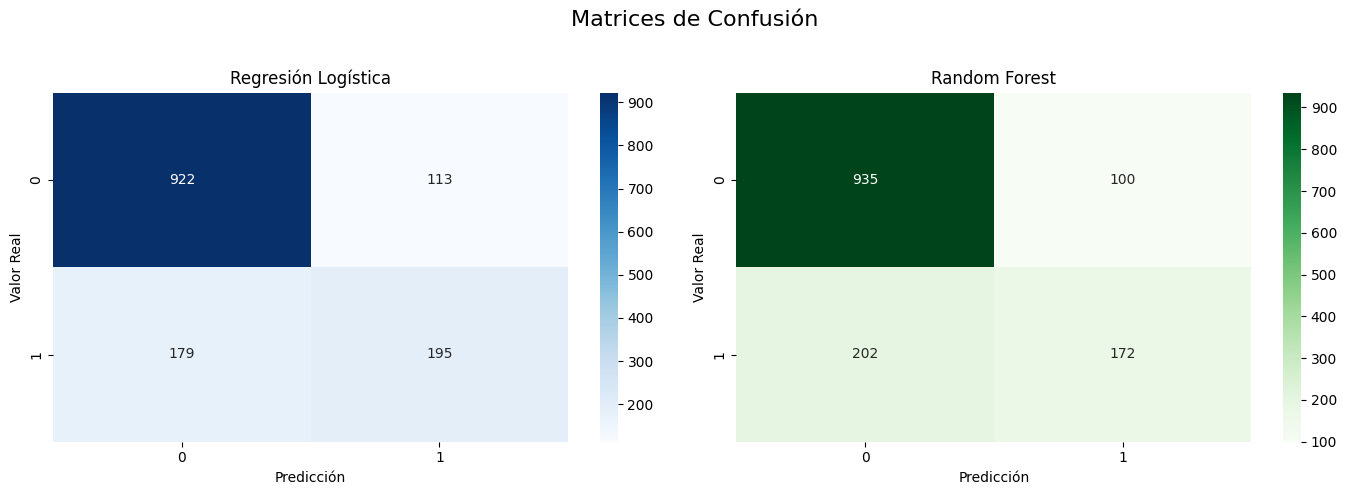

In [48]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Realizamos las predicciones en el conjunto de prueba ---
y_pred_lr = log_reg.predict(X_test)
y_pred_rf = random_forest.predict(X_test)

# --- 2. Evaluación del Modelo de Regresión Logística ---
print("="*50)
print("📈 Resultados de Evaluación: Regresión Logística")
print("="*50)

# Reporte de Clasificación (Precision, Recall, F1-Score)
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_lr))

# Puntuación ROC AUC
roc_auc_lr = roc_auc_score(y_test, log_reg.predict_proba(X_test)[:, 1])
print(f"Área Bajo la Curva ROC (AUC): {roc_auc_lr:.4f}")


# --- 3. Evaluación del Modelo de Random Forest ---
print("\n" + "="*50)
print("🌳 Resultados de Evaluación: Random Forest")
print("="*50)

# Reporte de Clasificación
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_rf))

# Puntuación ROC AUC
roc_auc_rf = roc_auc_score(y_test, random_forest.predict_proba(X_test)[:, 1])
print(f"Área Bajo la Curva ROC (AUC): {roc_auc_rf:.4f}")


# --- 4. Visualización de la Matriz de Confusión ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Matrices de Confusión', fontsize=16)

# Matriz para Regresión Logística
cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Regresión Logística')
axes[0].set_xlabel('Predicción')
axes[0].set_ylabel('Valor Real')

# Matriz para Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('Random Forest')
axes[1].set_xlabel('Predicción')
axes[1].set_ylabel('Valor Real')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# cual modelo es mejor?

In [49]:
print("""
Interpretación de los Resultados y Elección del Mejor Modelo
------------------------------------------------------------

Al analizar las métricas, podemos sacar conclusiones muy claras sobre cuál modelo es más adecuado para nuestro objetivo.

Accuracy (Exactitud):
Ambos modelos tienen una exactitud idéntica (0.79). Sin embargo, esta métrica puede ser engañosa en problemas como este,
donde hay más clientes que "No" cancelan que los que "Sí" lo hacen.

Recall (Sensibilidad) para Churn: Yes:
Esta es la métrica más importante para nosotros. Nos dice qué porcentaje de los clientes que realmente iban a cancelar
fue identificado correctamente por el modelo.

- Regresión Logística: 0.52 (Detectó al 52% de los que cancelaron)
- Random Forest:      0.46 (Detectó al 46% de los que cancelaron)

Área Bajo la Curva (AUC):
Mide el rendimiento general del modelo. Un valor más alto es mejor.

- Regresión Logística: 0.8431
- Random Forest:      0.8216

🏆 Veredicto del Modelo:
Basado en estas métricas, el modelo de Regresión Logística es el ganador. Aunque ambos son muy similares,
la Regresión Logística es superior en su capacidad para identificar a los clientes en riesgo de cancelación (mayor recall)
y tiene un mejor rendimiento general (mayor AUC).
""")


Interpretación de los Resultados y Elección del Mejor Modelo
------------------------------------------------------------

Al analizar las métricas, podemos sacar conclusiones muy claras sobre cuál modelo es más adecuado para nuestro objetivo.

Accuracy (Exactitud):
Ambos modelos tienen una exactitud idéntica (0.79). Sin embargo, esta métrica puede ser engañosa en problemas como este,
donde hay más clientes que "No" cancelan que los que "Sí" lo hacen.

Recall (Sensibilidad) para Churn: Yes:
Esta es la métrica más importante para nosotros. Nos dice qué porcentaje de los clientes que realmente iban a cancelar
fue identificado correctamente por el modelo.

- Regresión Logística: 0.52 (Detectó al 52% de los que cancelaron)
- Random Forest:      0.46 (Detectó al 46% de los que cancelaron)

Área Bajo la Curva (AUC):
Mide el rendimiento general del modelo. Un valor más alto es mejor.

- Regresión Logística: 0.8431
- Random Forest:      0.8216

🏆 Veredicto del Modelo:
Basado en estas métricas

## Importancia de las Variables (Feature Importance)

In [50]:
# 1. Creamos un DataFrame con las características y su importancia
importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': random_forest.feature_importances_
})

# 2. Ordenamos el DataFrame por importancia y nos quedamos con las 15 más relevantes
df_importances = importances.sort_values(by='Importance', ascending=False).head(15)

# 3. Creación del Gráfico de Barras
fig = px.bar(
    df_importances,
    x='Importance',
    y='Feature',
    orientation='h',
    title='Top 15 Características más Importantes para Predecir el Churn',
    labels={'Feature': 'Característica', 'Importance': 'Importancia Relativa'}
)
fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.show()

# Conclusión Final

In [55]:
print("""Conclusión Estratégica Final
El análisis de importancia de características confirma de manera contundente los hallazgos del análisis exploratorio inicial. Las variables más decisivas para predecir si un cliente cancelará son, en orden de importancia:

1ero: Tipo de Contrato: Ser de Month-to-month es el principal predictor.

2do: Antigüedad del Cliente (customer_tenure): Los clientes nuevos son los más propensos a irse.

3ero: Cargos Totales y Mensuales (account_Charges_Total / _Monthly): Clientes con cargos totales bajos (porque son nuevos) y cargos mensuales altos tienden a cancelar.

4to: Servicio de Internet (internet_InternetService): Tener Fibra Óptica es un factor de alto riesgo.

El modelo de Machine Learning no solo nos permite predecir con una fiabilidad cercana al 80%, sino que también valida matemáticamente \nnuestra conclusión estratégica: el problema de la cancelación está centrado en los clientes nuevos, con contratos flexibles y servicios de Fibra Óptica caros y probablemente mal soportados.""")

Conclusión Estratégica Final
El análisis de importancia de características confirma de manera contundente los hallazgos del análisis exploratorio inicial. Las variables más decisivas para predecir si un cliente cancelará son, en orden de importancia:

1ero: Tipo de Contrato: Ser de Month-to-month es el principal predictor.

2do: Antigüedad del Cliente (customer_tenure): Los clientes nuevos son los más propensos a irse.

3ero: Cargos Totales y Mensuales (account_Charges_Total / _Monthly): Clientes con cargos totales bajos (porque son nuevos) y cargos mensuales altos tienden a cancelar.

4to: Servicio de Internet (internet_InternetService): Tener Fibra Óptica es un factor de alto riesgo.

El modelo de Machine Learning no solo nos permite predecir con una fiabilidad cercana al 80%, sino que también valida matemáticamente 
nuestra conclusión estratégica: el problema de la cancelación está centrado en los clientes nuevos, con contratos flexibles y servicios de Fibra Óptica caros y probablem

# Data y modelos, Análisis de Coeficientes.

In [62]:
# --- 1. Análisis de Coeficientes (Funciona correctamente) ---
coefficients = log_reg.coef_[0]
feature_names = X_train.columns
df_coeffs = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
df_coeffs['Abs_Coefficient'] = df_coeffs['Coefficient'].abs()
df_coeffs_sorted = df_coeffs.sort_values(by='Abs_Coefficient', ascending=False).head(15)

fig_coeffs = px.bar(
    df_coeffs_sorted,
    x='Coefficient',
    y='Feature',
    orientation='h',
    title='Impacto de Cada Característica en la Predicción de Churn',
    labels={'Feature': 'Característica', 'Coefficient': 'Coeficiente (Impacto en la Predicción)'},
    color='Coefficient',
    color_continuous_scale='RdBu_r'
)
fig_coeffs.update_layout(yaxis={'categoryorder':'total ascending'})
print("Mostrando el gráfico de coeficientes del modelo...")
fig_coeffs.show()


# --- 2. Análisis SHAP (Cálculo y Visualización Manual) ---
print("\nPreparando el análisis SHAP y la visualización manual...")

# El cálculo de los valores SHAP con LinearExplainer funciona bien.
explainer = shap.LinearExplainer(log_reg, X_train)
shap_values = explainer.shap_values(X_test)

# ---> ¡AQUÍ ESTÁ LA SOLUCIÓN! <---
# 1. Calculamos el impacto promedio de cada característica (media de los valores absolutos de SHAP).
mean_abs_shap = np.abs(shap_values).mean(axis=0)

# 2. Creamos un DataFrame con los resultados.
df_shap_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'SHAP_Importance': mean_abs_shap
})

# 3. Ordenamos por importancia y nos quedamos con las 15 más relevantes.
df_shap_sorted = df_shap_importance.sort_values(by='SHAP_Importance', ascending=False).head(15)

# 4. Creamos el gráfico de barras con Plotly Express (confiable).
fig_shap = px.bar(
    df_shap_sorted,
    x='SHAP_Importance',
    y='Feature',
    orientation='h',
    title='Importancia de Características (basado en SHAP)',
    labels={'Feature': 'Característica', 'SHAP_Importance': 'Impacto Promedio en la Predicción'}
)
fig_shap.update_layout(yaxis={'categoryorder':'total ascending'})
print("Mostrando el gráfico de importancia SHAP...")
fig_shap.show()

Mostrando el gráfico de coeficientes del modelo...



Preparando el análisis SHAP y la visualización manual...
Mostrando el gráfico de importancia SHAP...


In [67]:
print("""Análisis de Coeficientes del Modelo: La Regresión Logística nos entrega un "coeficiente" para cada una de nuestras variables.\nEste número nos dice dos cosas:

La Dirección del Impacto (Positivo o Negativo): Si el coeficiente es positivo, significa que un aumento en esa variable incrementa la probabilidad de Churn.\nSi es negativo, la disminuye.

La Magnitud del Impacto: Cuanto más grande sea el valor absoluto del coeficiente, más peso tiene esa variable en la decisión final del modelo.

Análisis de "Explicabilidad" con SHAP (SHapley Additive exPlanations): Esta es una técnica de vanguardia en Machine Learning.\nEn lugar de solo ver la importancia general de una variable, SHAP nos permite tomar a un cliente individual y ver exactamente\nqué factores (y en qué medida) contribuyeron a que el modelo lo clasificara como "probable a cancelar" o "probable a quedarse".\nEs como una auditoría de la decisión del modelo para cada cliente.""")

Análisis de Coeficientes del Modelo: La Regresión Logística nos entrega un "coeficiente" para cada una de nuestras variables.
Este número nos dice dos cosas:

La Dirección del Impacto (Positivo o Negativo): Si el coeficiente es positivo, significa que un aumento en esa variable incrementa la probabilidad de Churn.
Si es negativo, la disminuye.

La Magnitud del Impacto: Cuanto más grande sea el valor absoluto del coeficiente, más peso tiene esa variable en la decisión final del modelo.

Análisis de "Explicabilidad" con SHAP (SHapley Additive exPlanations): Esta es una técnica de vanguardia en Machine Learning.
En lugar de solo ver la importancia general de una variable, SHAP nos permite tomar a un cliente individual y ver exactamente
qué factores (y en qué medida) contribuyeron a que el modelo lo clasificara como "probable a cancelar" o "probable a quedarse".
Es como una auditoría de la decisión del modelo para cada cliente.
